# Hierarchichal Bayesian Model

In [1]:
import jax
jax.default_backend()
jax.devices()

2023-01-20 17:13:24.355701: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:
2023-01-20 17:13:24.589975: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:
2023-01-20 17:13:24.593295: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-01-20 17:13:24.939881: E external/org_

[CpuDevice(id=0)]

In [2]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np
from numpy.random import normal


#import theano


import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-01-20 17:13:27.604178


# Import data

In [3]:
import os
import requests
import pandas as pd
import warnings
from datetime import datetime

def download_files(filepath, N):
    url = f"https://www.football-data.co.uk/mmz4281/{filepath}/{N}.csv"
    response = requests.get(url)
    directory = "/home/data-scientist/Documents/Football Modelling/Data"
    os.makedirs(directory, exist_ok=True)
    file_name = f"{filepath}_{N}_{datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv"
    open(os.path.join(directory, file_name), "wb").write(response.content)
    df = pd.read_csv(os.path.join(directory, file_name),encoding='latin1')
    return df

def data_quality_checks(df):
    if df.isnull().sum().sum() > 0:
        raise ValueError("Dataframe contains missing values")
    if df.duplicated().sum() > 0:
        raise ValueError("Dataframe contains duplicates")

filepath_values = ["1819", "1920", "2021", "2122", "2223"]
N_values = ["E0", "E1", "E2", "E3", "EC"]
directory = "/home/data-scientist/Documents/Football Modelling/Data"



final_df_file = os.path.join(directory, "final_df.csv")
if os.path.isfile(final_df_file):
    final_df = pd.read_csv(final_df_file)
else:
    final_df = pd.DataFrame()
    for filepath in filepath_values:
        for N in N_values:
            df = download_files(filepath, N)
            try:
                data_quality_checks(df)
            except ValueError as e:
                warnings.warn(f"{filepath}_{N} has {e}")
            final_df = pd.concat([final_df, df], ignore_index=True)
    final_df.to_csv(final_df_file, index=False)




# final_df = pd.DataFrame()
# for filepath in filepath_values:
#     for N in N_values:
#         df = download_files(filepath, N)
#         try:
#             data_quality_checks(df)
#         except ValueError as e:
#             warnings.warn(f"{filepath}_{N} has {e}")
#         final_df = pd.concat([final_df, df], ignore_index=True)
# final_df.to_csv(os.path.join(directory, "final_df.csv"), index=False)


/tmp/ipykernel_5217/3768584145.py:31: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv(final_df_file)


In [4]:
df = final_df

columns_to_keep = ["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HTHG","HTAG","HTR"]
df = df[columns_to_keep].copy()
df["Date"] = pd.to_datetime(df['Date'])
df["Month"] = df['Date'].dt.month
df["Game"] = df.apply(lambda x: x["HomeTeam"] + " vs " + x["AwayTeam"], axis=1)


df.loc[:, 'Total Goals'] = df[['FTHG', 'FTAG']].sum(axis=1)
df.loc[:, 'Total FHG'] = df[['HTHG', 'HTAG']].sum(axis=1)
df.loc[:, 'Both_Teams_Score'] = np.where((df['FTHG'] > 0) & (df['FTAG'] > 0), 1, 0)
df.loc[:, 'Under 2.5 Goals'] = np.where((df['Total Goals'] < 2.5) , 1, 0)
df.loc[:, 'Over 2.5 Goals'] = np.where((df['Total Goals'] > 2.5) , 1, 0)
df.loc[:, 'Under 0.5 Goals'] = np.where((df['Total Goals'] < 0.5) , 1, 0)
df.loc[:, 'Over 0.5 Goals'] = np.where((df['Total Goals'] > 0.5) , 1, 0)
df.loc[:, 'Under 1.5 Goals'] = np.where((df['Total Goals'] < 1.5) , 1, 0)
df.loc[:, 'Over 1.5 Goals'] = np.where((df['Total Goals'] > 1.5) , 1, 0)
df.loc[:, 'Under 3.5 Goals'] = np.where((df['Total Goals'] < 3.5) , 1, 0)
df.loc[:, 'Over 3.5 Goals'] = np.where((df['Total Goals'] > 3.5) , 1, 0)
df.loc[:, 'Under 4.5 Goals'] = np.where((df['Total Goals'] < 4.5) , 1, 0)
df.loc[:, 'Over 4.5 Goals'] = np.where((df['Total Goals'] > 4.5) , 1, 0)
df.loc[:, 'First Half Goals 0.5'] = np.where((df['Total FHG'] < 0.5) , 1, 0)
df.loc[:, 'First Half Goals 1.5'] = np.where((df['Total FHG'] < 1.5) , 1, 0)
df['Div'] = df['Div'].astype('category')
df['HomeTeam'] = df['HomeTeam'].astype('category')
df['AwayTeam'] = df['AwayTeam'].astype('category')
df['Game'] = df['Game'].astype('category')




/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '20/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Par

In [5]:
#df_prior = df.loc[df['Date'] <= (max(df['Date']) - pd.Timedelta(days=730))]
#df_observed = (df.loc[df['Date'] >= (max(df['Date']) - pd.Timedelta(days=730))])

df_observed = df

print(df_observed.shape)
#print(df_prior.shape)

(11289, 27)


# Data Anaysis 

In [6]:
df_observed["HomeTeam"].value_counts().to_csv('homecounts')

<AxesSubplot:>

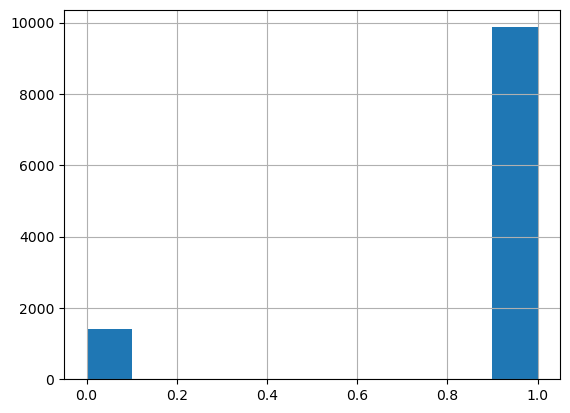

In [7]:
df_observed["Under 4.5 Goals"].hist()

# generic model

In [8]:
# Hierarchies
HomeTeam_idx = df_observed.HomeTeam.cat.codes.values
HomeTeam_codes = df_observed.HomeTeam.cat.categories
Div_idx = df_observed.Div.cat.codes.values
Div_codes = df_observed.Div.cat.categories
Game_idx = df_observed.Game.cat.codes.values
Game_codes = df_observed.Game.cat.categories

n_HomeTeam = HomeTeam_codes.size
n_Div = Div_codes.size
n_Game = Game_codes.size

# Parameters
BothTeamsScore_game = np.array(df_observed["Both_Teams_Score"])
U2_5G_game = np.array(df_observed["Under 2.5 Goals"])
U0_5G_game = np.array(df_observed["Under 0.5 Goals"])
U1_5G_game = np.array(df_observed["Under 1.5 Goals"])
U3_5G_game = np.array(df_observed["Under 3.5 Goals"])
U4_5G_game = np.array(df_observed["Under 4.5 Goals"])
FH_U0_5G_game = np.array(df_observed['First Half Goals 0.5'])
FH_U1_5G_game = np.array(df_observed['First Half Goals 1.5'])

# unique_teams = np.unique(Div_idx)
# num_unique_teams = len(unique_teams)
# print(num_unique_teams)


print('n_HomeTeam',n_HomeTeam)
print('n_Div', n_Div)

print(n_HomeTeam)
#with np.printoptions(threshold=np.inf):
    #print(HomeTeam_idx)


n_HomeTeam 126
n_Div 5
126


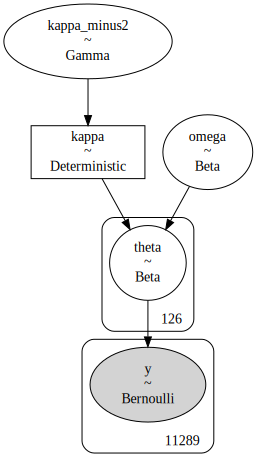

In [9]:
with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_HomeTeam)
        
    y = pm.Bernoulli('y', theta[HomeTeam_idx], observed=U4_5G_game)    

pm.model_to_graphviz(hierarchical_model)



In [10]:
# with pm.Model() as hierarchical_model:
    
#     # Hyper parameters
#     omega = pm.Beta('omega', 1, 1)
#     kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
#     kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
#     # Parameters for categories (Divisions)
#     omega_c = pm.Beta('omega_c',
#                        omega * (kappa-2) + 1, (1-omega) * (kappa-2) + 1,
#                        shape = n_Div)
    
#     kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
#                               0.01, 0.01,
#                               shape = n_Div)
    
#     kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
    
#     # parameter estimates at home team level
#     theta = pm.Beta('theta',
#                      omega_c[Div_idx] * (kappa_c[Div_idx]-2) + 1,
#                     (1-omega_c[Div_idx]) * (kappa_c[Div_idx]-2) + 1,
#                      shape = n_HomeTeam)
    
#     y = pm.Bernoulli('y', theta[HomeTeam_idx], observed=df_observed.Both_Teams_Score)
    
# from graphviz import Digraph




In [11]:
# #graph = pm.model_to_graphviz(hierarchical_model)
# #graph
# #graph.format = 'png'
# #graph.render('hierarchical_model')
# pm.model_to_graphviz(hierarchical_model)

# MCMC Sampling

In [12]:
with hierarchical_model:
    trace = pm.sample(draws=2000, tune=3000, target_accept=0.95, cores=4, idata_kwargs={"log_likelihood": True}, return_inferencedata=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 57 seconds.


In [13]:
trace

<MultiTrace: 4 chains, 2000 iterations, 7 variables>

## Sample data storage 

In [14]:
#var_names = ['omega', 'kappa_minus2', 'theta', "y"]

with hierarchical_model:
    posterior_predictive  = pm.sample_posterior_predictive(trace=trace, 
                                         return_inferencedata=False)


Sampling: [y]


In [15]:
var_names = ["kappa_minus2", "omega"]
with hierarchical_model:
    prior_predictive = pm.sample_prior_predictive(samples=2000, 
                                                  #var_names=var_names,
                                                 return_inferencedata=False,
                                                 )


Sampling: [kappa_minus2, omega, theta, y]


In [16]:
with hierarchical_model:
    idata = pm.to_inference_data(trace=trace, posterior_predictive=posterior_predictive, prior=prior_predictive, log_likelihood=True)
#idata = pm.from_pymc3(trace=trace, posterior_predictive=posterior_predictive, prior=prior_predictive)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

# Model Diagnostics: Prior Predictive Plots

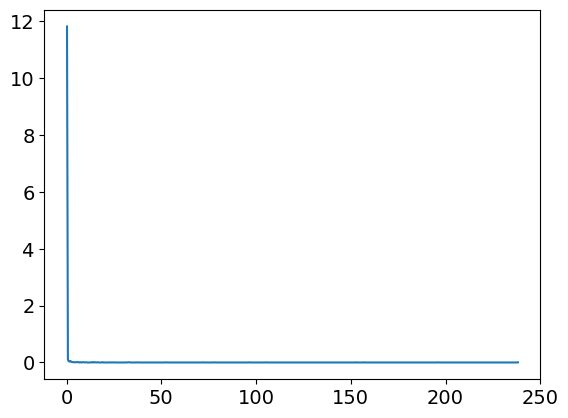

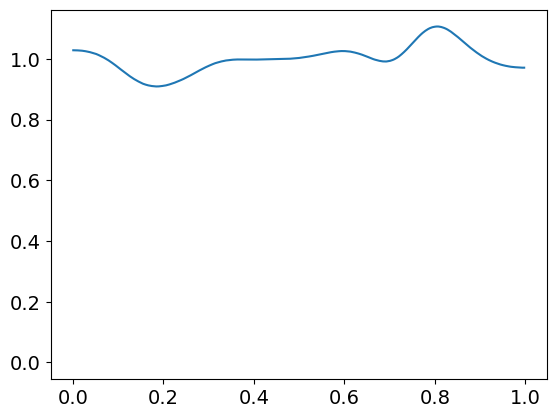

In [18]:
for variable in var_names:
    az.plot_dist(idata.prior[variable]) 
    plt.show()

# Model Diagnostics: Model Convergence

array([[<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>],
       [<AxesSubplot:title={'center':'kappa_minus2'}>,
        <AxesSubplot:title={'center':'kappa_minus2'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>]], dtype=object)

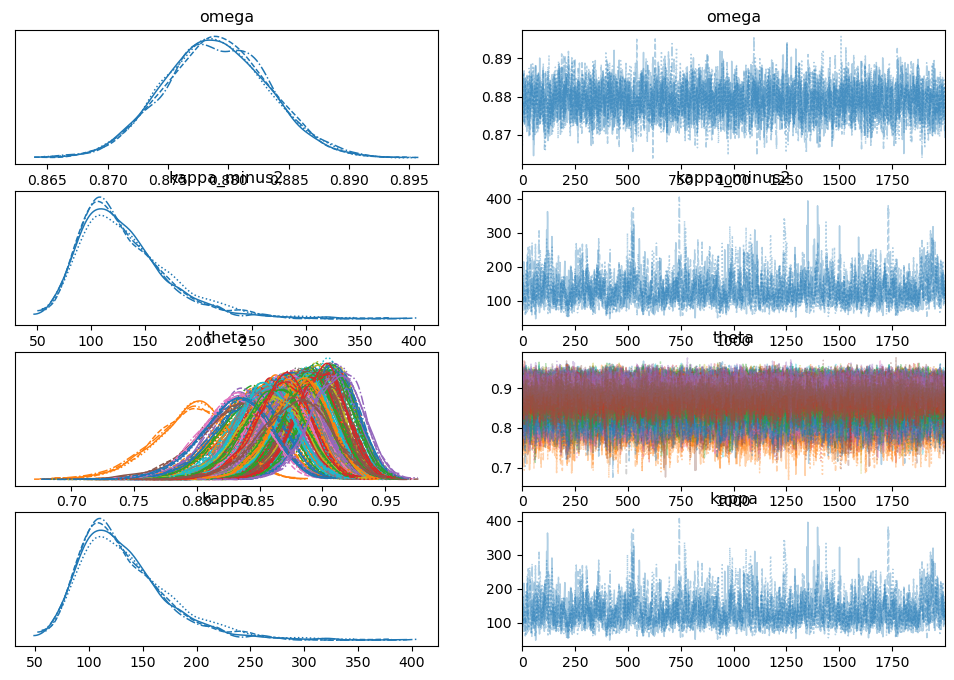

In [21]:
az.plot_trace(idata)

In [22]:
az.summary(idata)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
omega           0.879   0.004   0.871    0.887        0.0     0.00    2825.0   
kappa_minus2  131.004  42.945  64.684  212.854        1.4     0.99    1012.0   
theta[0]        0.875   0.022   0.833    0.916        0.0     0.00    7858.0   
theta[1]        0.844   0.025   0.797    0.888        0.0     0.00    7277.0   
theta[2]        0.884   0.021   0.845    0.924        0.0     0.00   10663.0   
...               ...     ...     ...      ...        ...      ...       ...   
theta[122]      0.860   0.024   0.815    0.906        0.0     0.00    9360.0   
theta[123]      0.867   0.023   0.826    0.911        0.0     0.00   12174.0   
theta[124]      0.911   0.020   0.872    0.946        0.0     0.00    5310.0   
theta[125]      0.877   0.028   0.824    0.928        0.0     0.00    8987.0   
kappa         133.004  42.945  66.684  214.854        1.4     0.99    1012.0   

              ess_tail  r_hat  
omega           4860.0    1.0  
kappa_minus2    1794.0    1.0  
theta[0]        5012.0    1.0  
theta[1]        5800.0    1.0  
theta[2]        5526.0    1.0  
...                ...    ...  
theta[122]      5177.0    1.0  
theta[123]      5284.0    1.0  
theta[124]      4913.0    1.0  
theta[125]      4987.0    1.0  
kappa           1794.0    1.0  

[129 rows x 9 columns]

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (129) in plot_mcse, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'kappa_minus2'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n0'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n1'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':'theta\n2'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n3'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n4'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n5'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':'theta\n6'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n7'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
       

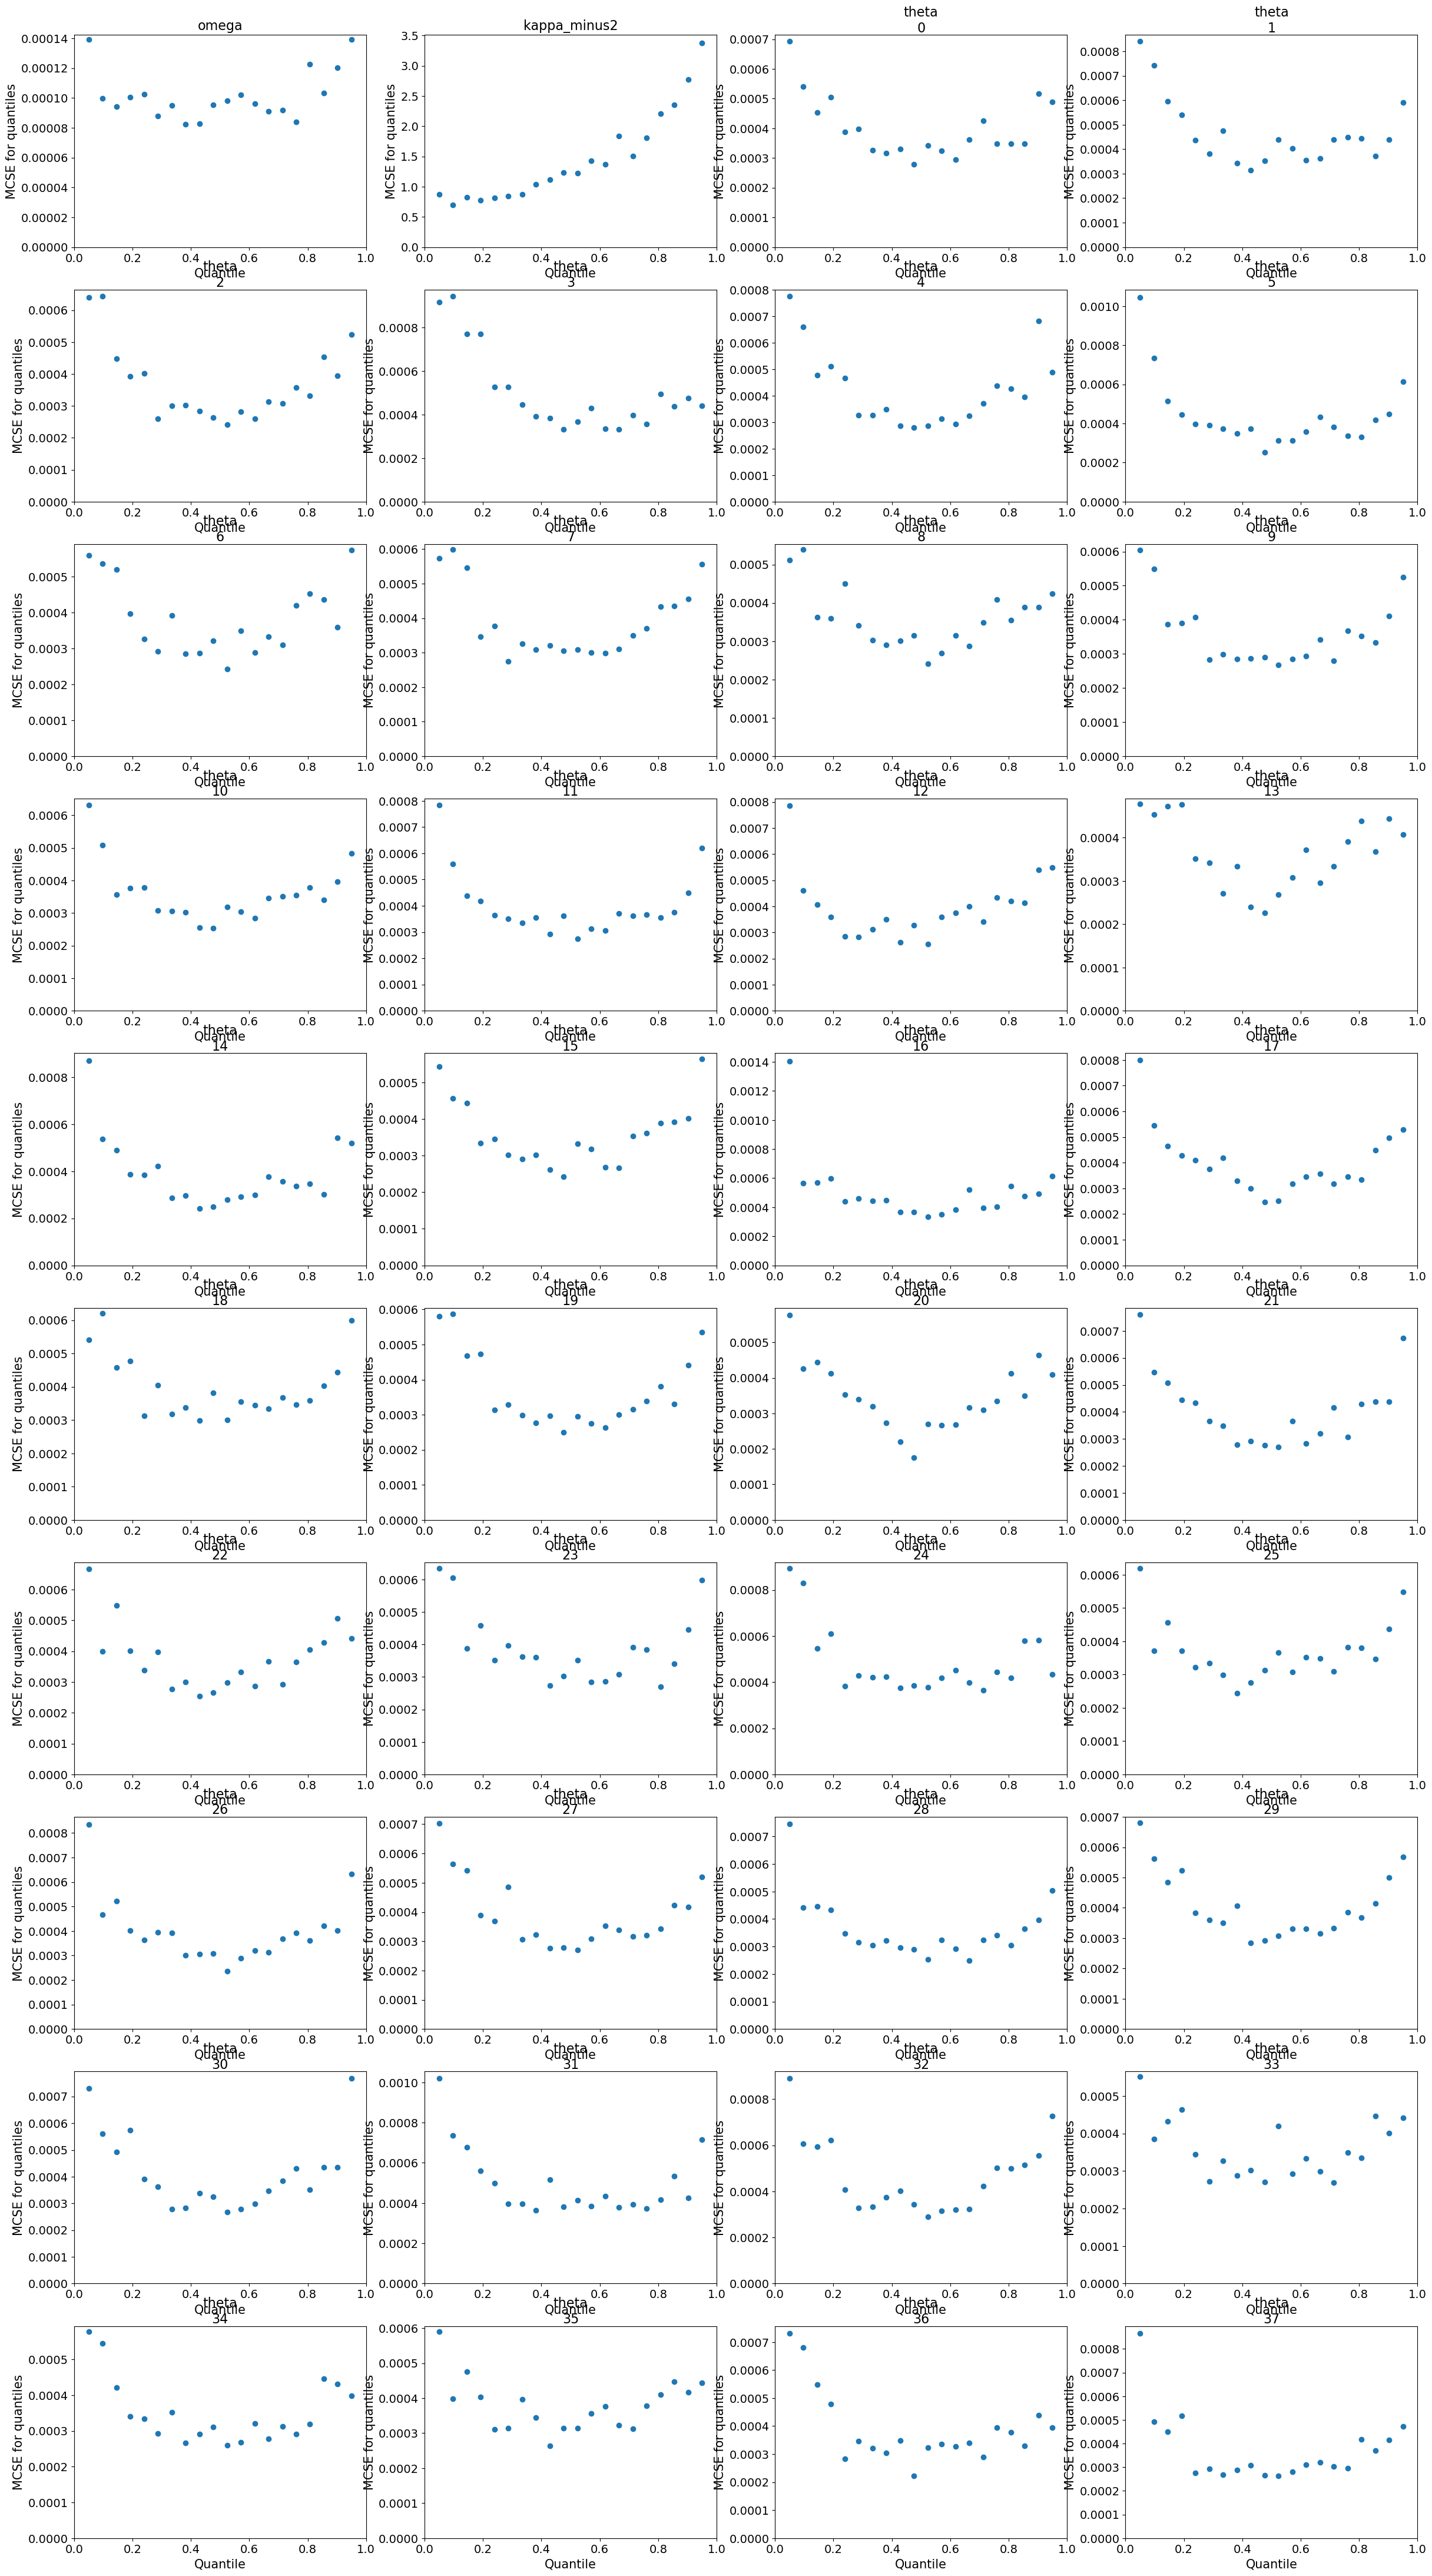

In [23]:
az.plot_mcse(idata)

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (129) in plot_ess, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'kappa_minus2'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n1'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<AxesSubplot:title={'center':'theta\n2'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n3'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n4'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n5'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<AxesSubplot:title={'center':'theta\n6'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n7'}, xlabel='Qua

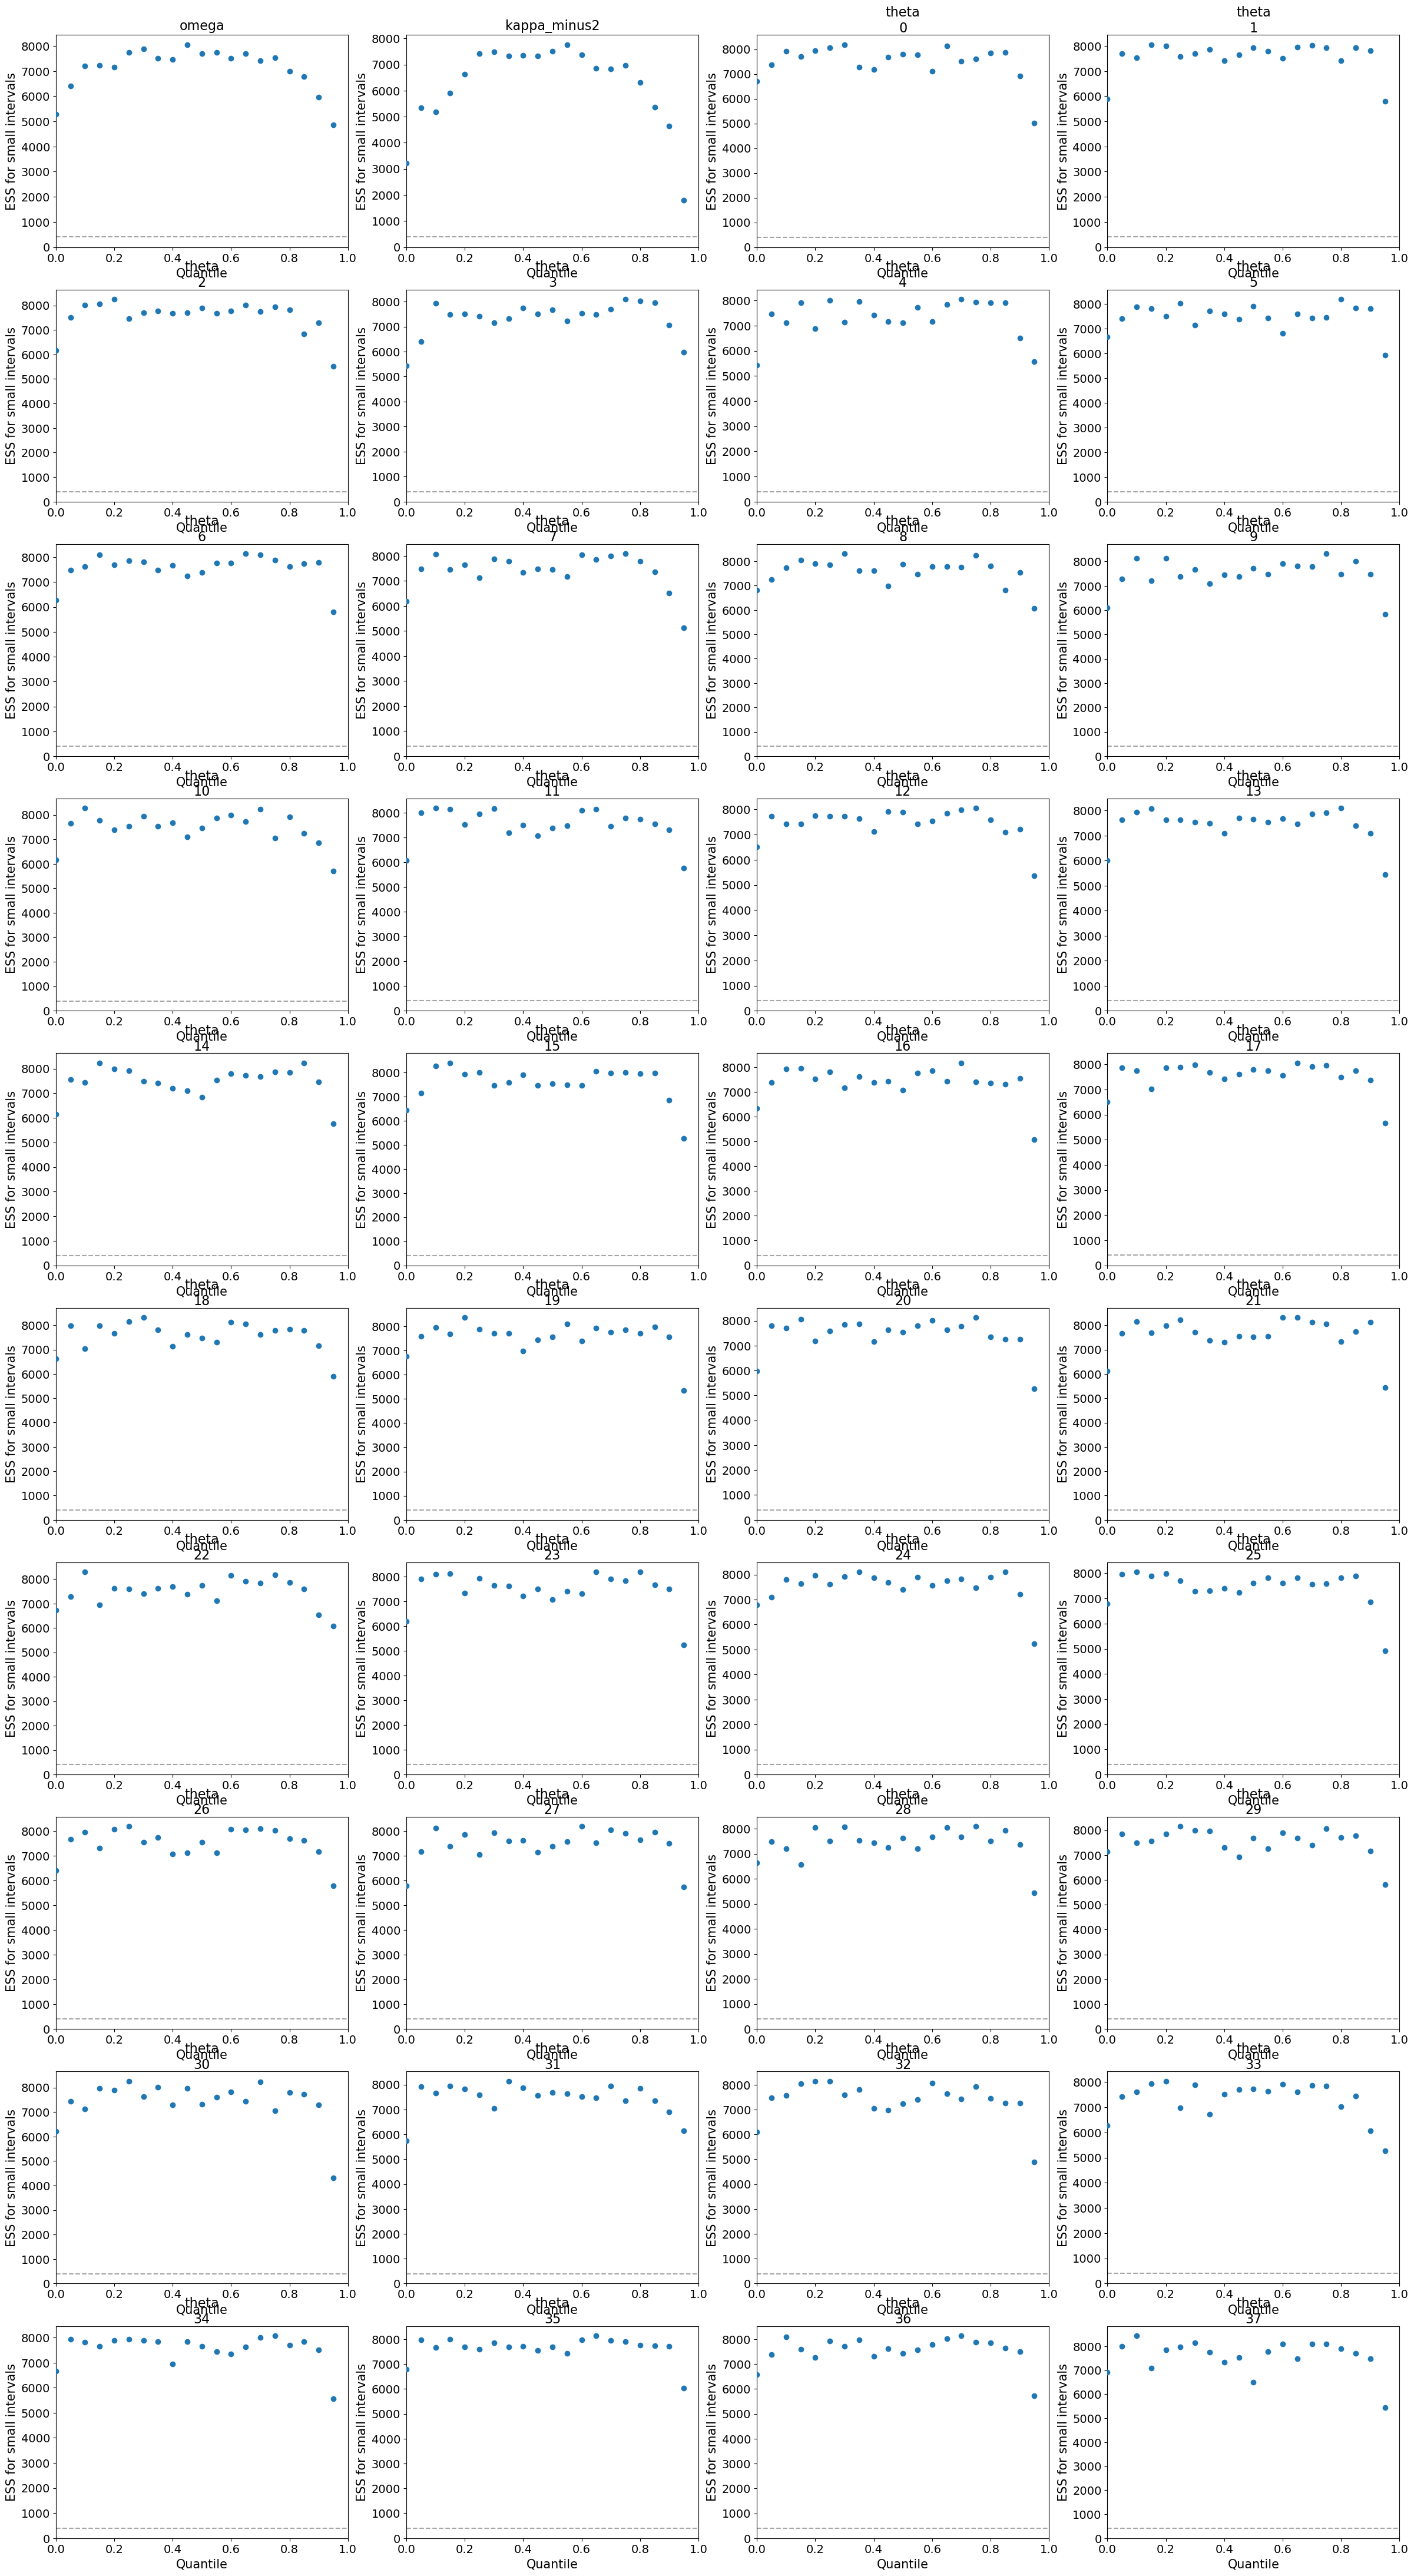

In [24]:
az.plot_ess(idata)

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (129) in plot_rank, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'kappa_minus2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'theta\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'theta\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n7'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n8'

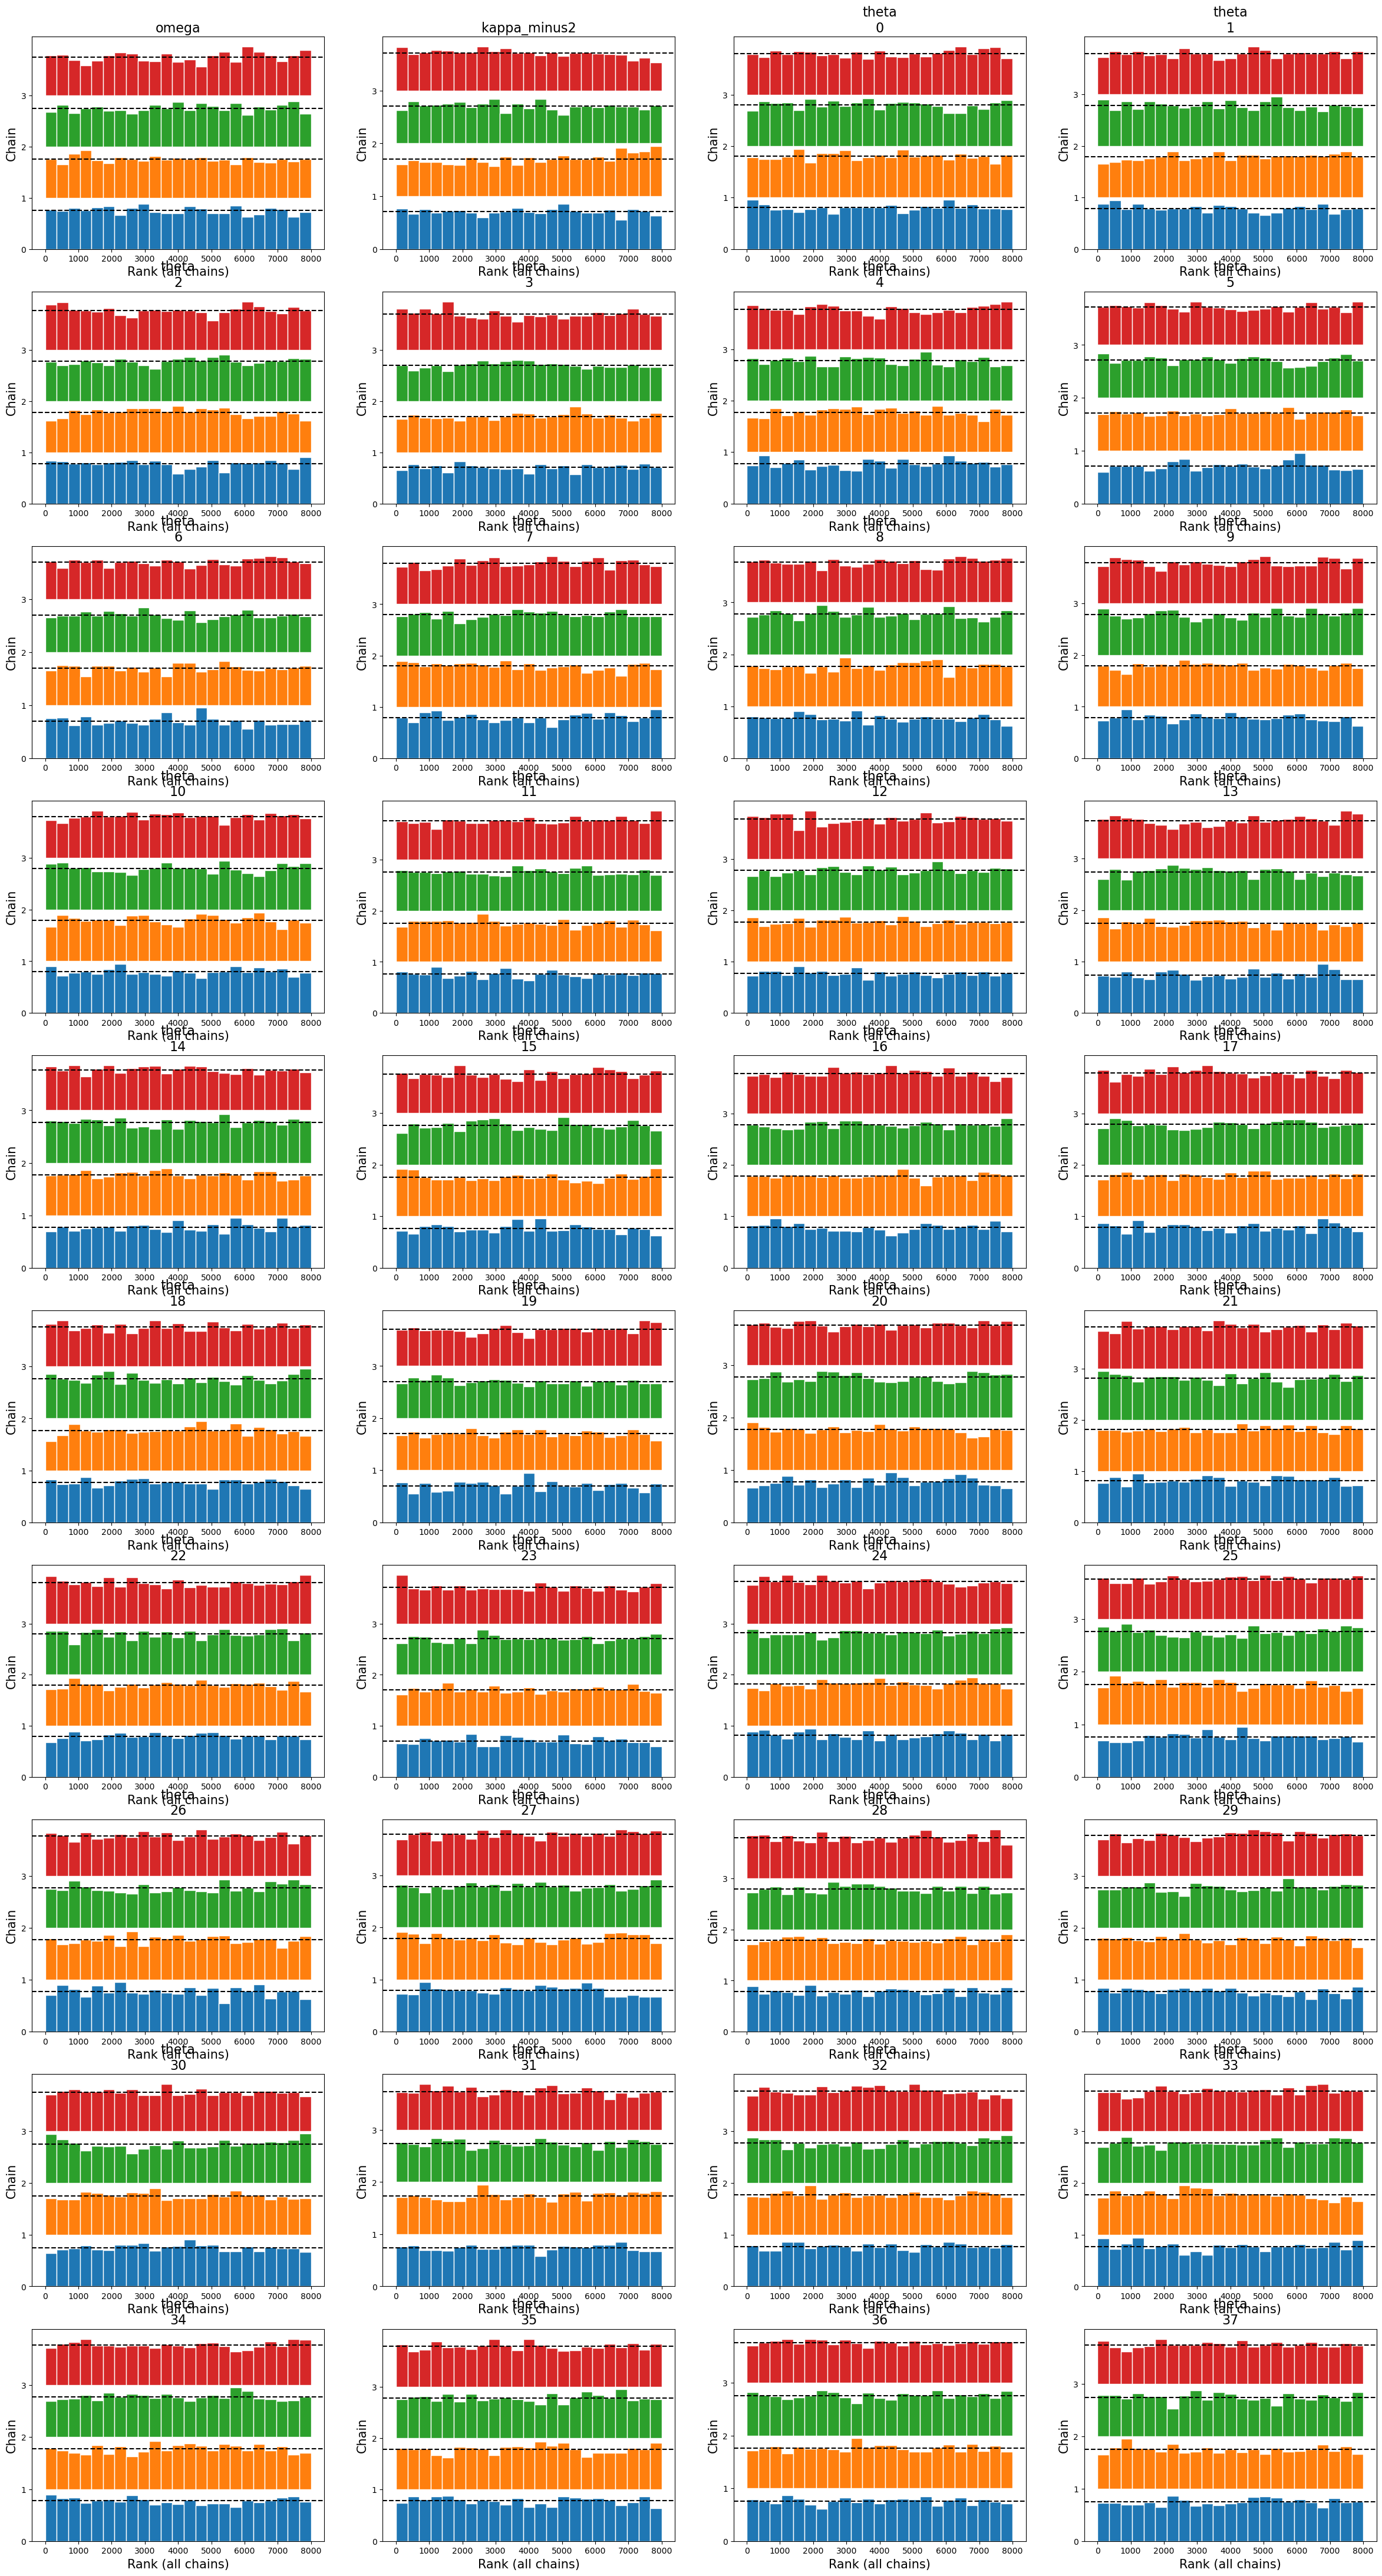

In [25]:
az.plot_rank(idata)
        

# Posterior predictive checks

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (128) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'kappa_minus2'}>,
        <AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>],
       [<AxesSubplot:title={'center':'theta\n2'}>,
        <AxesSubplot:title={'center':'theta\n3'}>,
        <AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>],
       [<AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>,
        <AxesSubplot:title={'center':'theta\n8'}>,
        <AxesSubplot:title={'center':'theta\n9'}>],
       [<AxesSubplot:title={'center':'theta\n10'}>,
        <AxesSubplot:title={'center':'theta\n11'}>,
        <AxesSubplot:title={'center':'theta\n12'}>,
        <AxesSubplot:title={'center':'theta\n13'}>],
       [<AxesSubplot:title={'center':'theta\n14'}>,
        <AxesSubplot:title={'center':'theta\n15'}>,
        <AxesSubplot:title={'center':'theta\n16'}>,
        <AxesSubplo

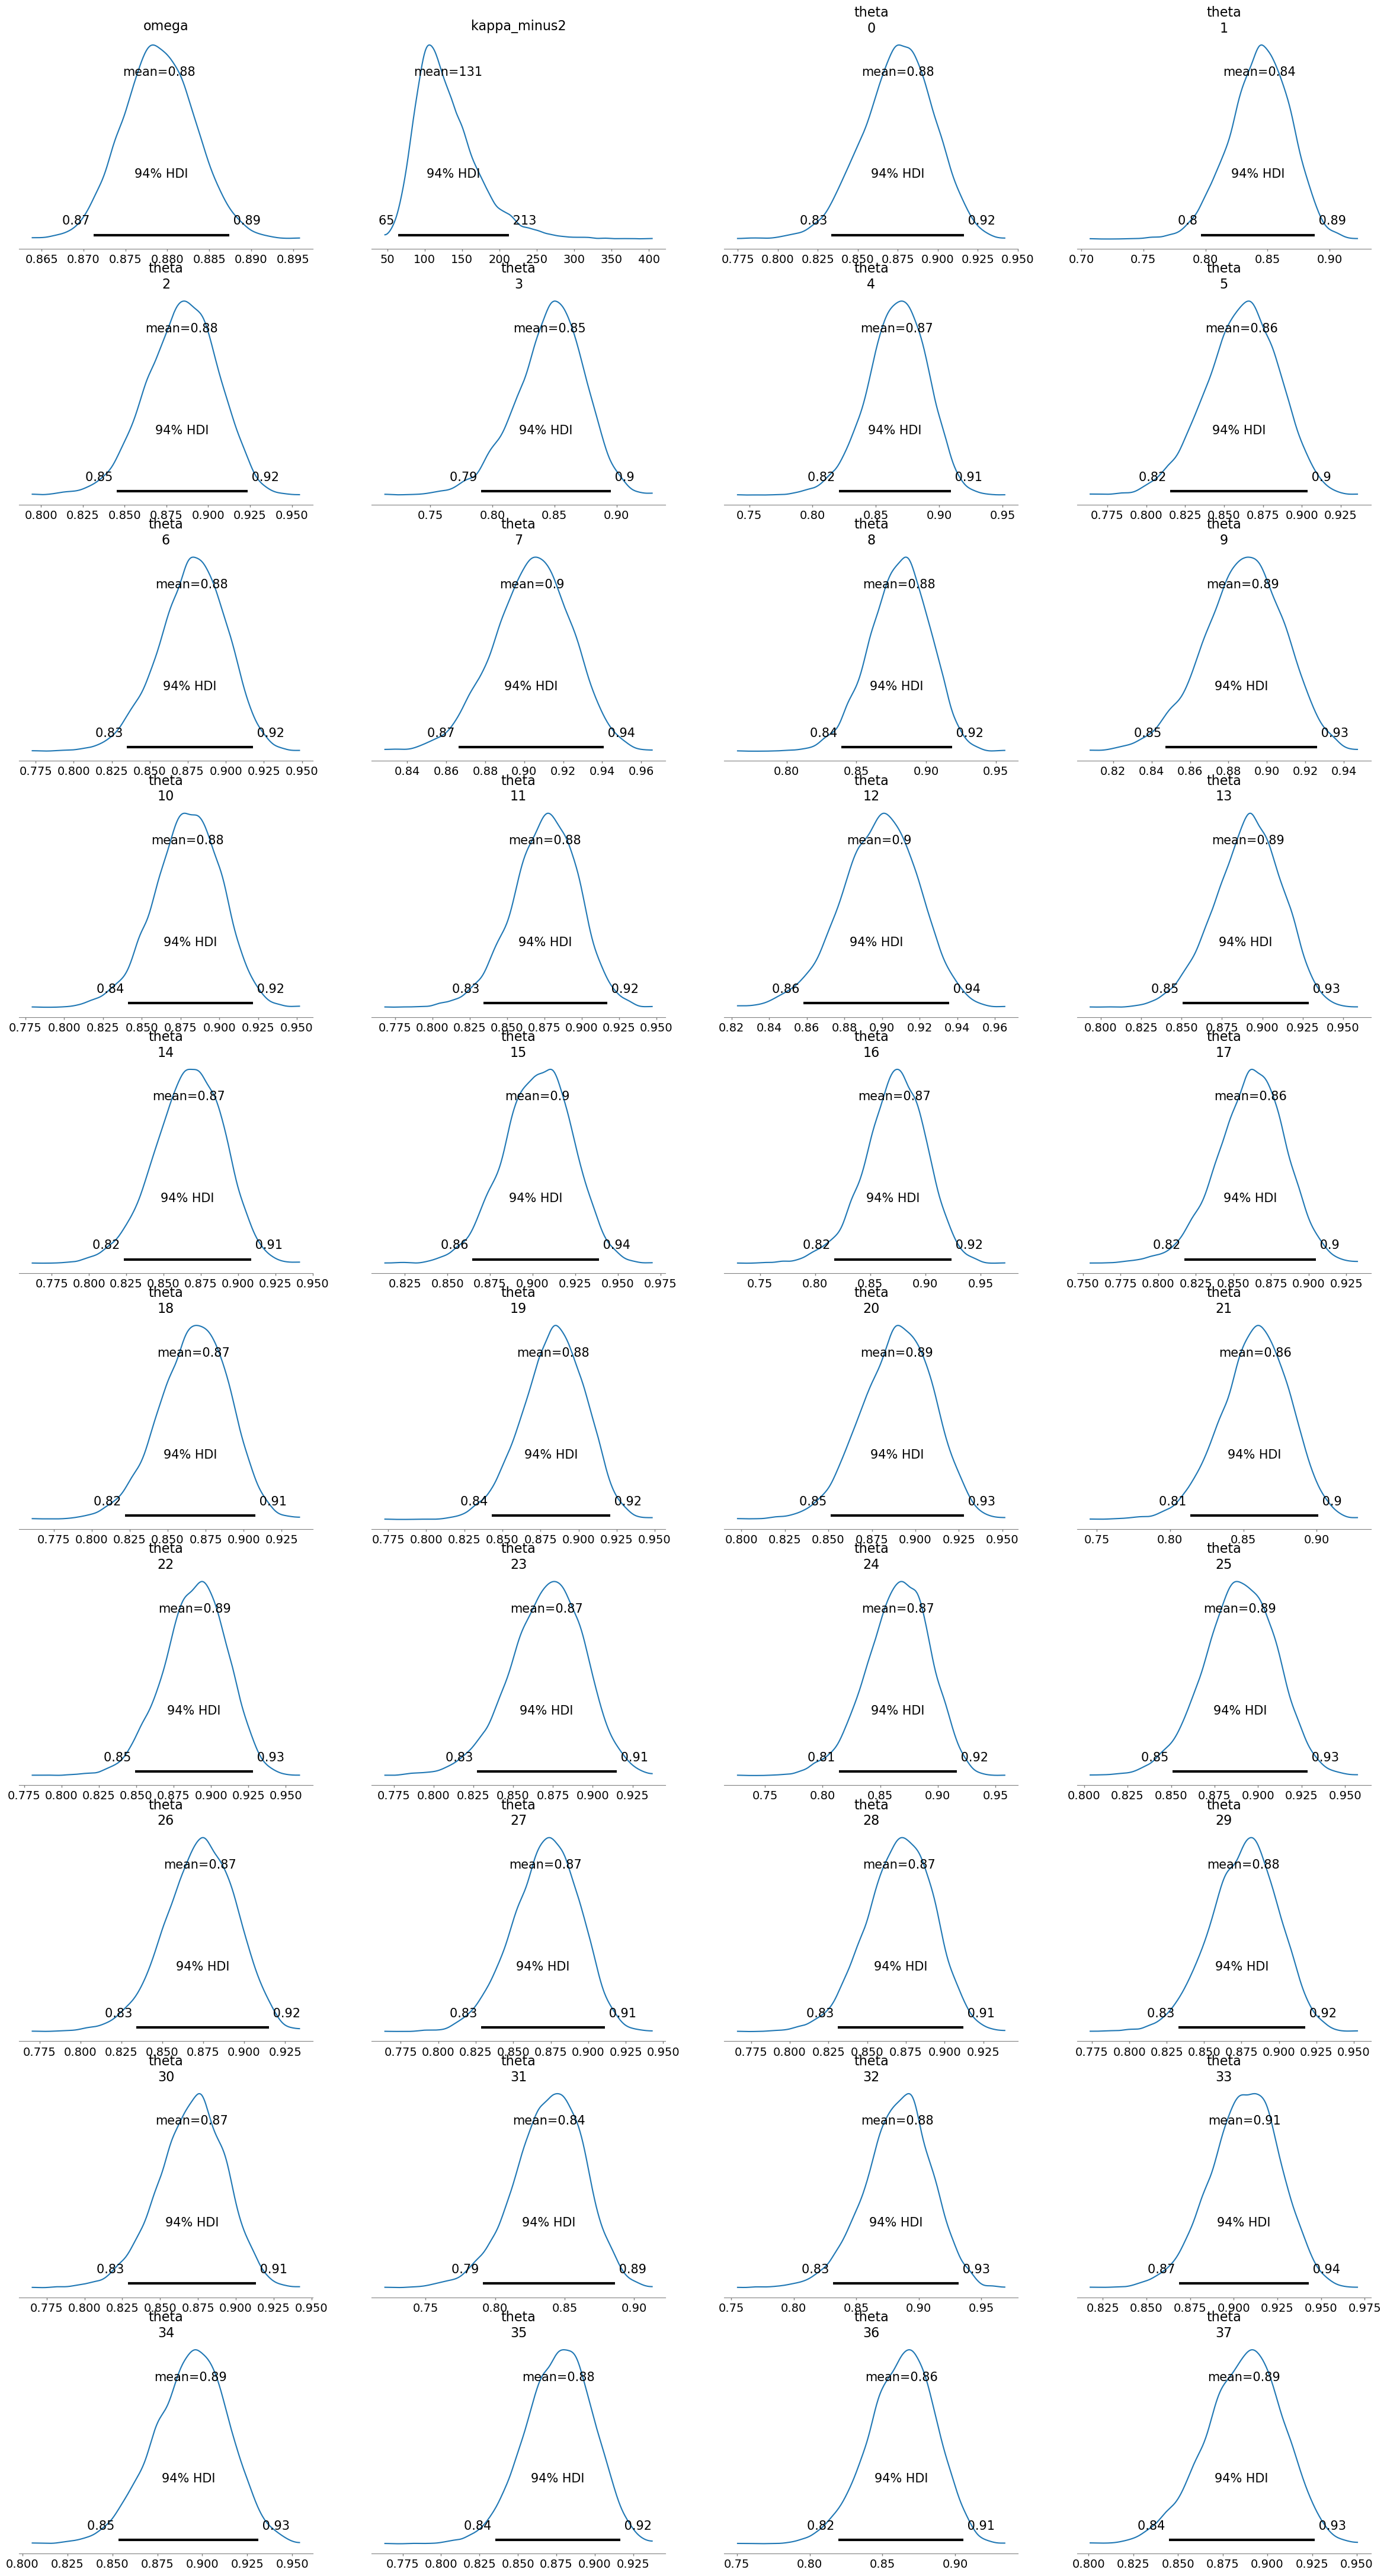

In [27]:
var_names = ['omega', 'kappa_minus2', 'theta']
#var_names = ['theta']

az.plot_posterior(idata, var_names=var_names) 


#for variable in var_names:
    #az.plot_posterior(ppc.posterior_predictive[variable]) 
    #plt.show()

# Out of sample predictive checks

<AxesSubplot:xlabel='y'>

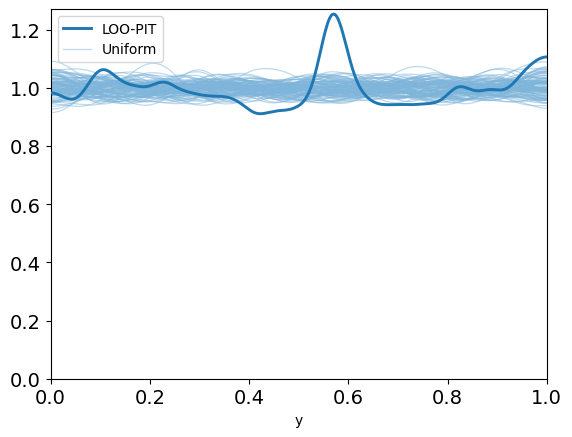

In [28]:
az.plot_loo_pit(idata=idata, y='y')